# Advanced Lane Finding Project 

By Pablo Sauras Perez

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
## 1. Compute the camera calibration using chessboard images
This code is was available in 'examples/example.ipynb'

In [377]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

In [378]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# chessboard
ny = 6
nx = 9

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow(write_name,img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()

### Calibrate, Calculate Distortion Coefficients and test undistorsion on an image
This code is from 'CarND-Camera-Calibration'

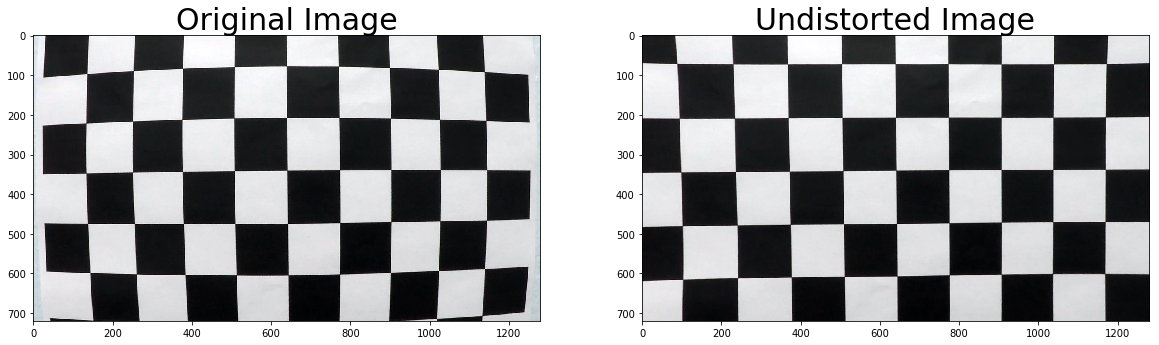

In [379]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
#mtx --> Calibration Matrix
#dist --> Distortion Coeficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#Calculate distortion coefficients
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/undistorded_calibration.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#I apply mtx and dist to each new frame
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline (single images)

## 2. Apply a distortion correction to raw images

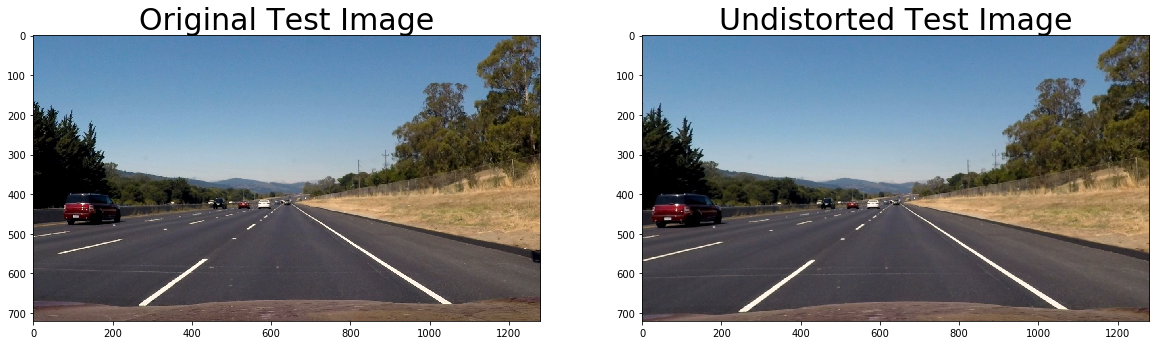

In [464]:
# Test undistortion on an image
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Calculate distortion coefficients
dst = cv2.undistort(img, mtx, dist, None, mtx)

cv2.imwrite('test_images/undistorded_test.jpg',cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Test Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Test Image', fontsize=30)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

This is the Thresholding step. Here I want to use various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible.

In [465]:
# Edit this function to create your own pipeline.
def pipeline_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    
    
    # Sobel x
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel S
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    color_binary = combined_binary
    
    
    return color_binary

Apply threshold pipeline and show one of the test results

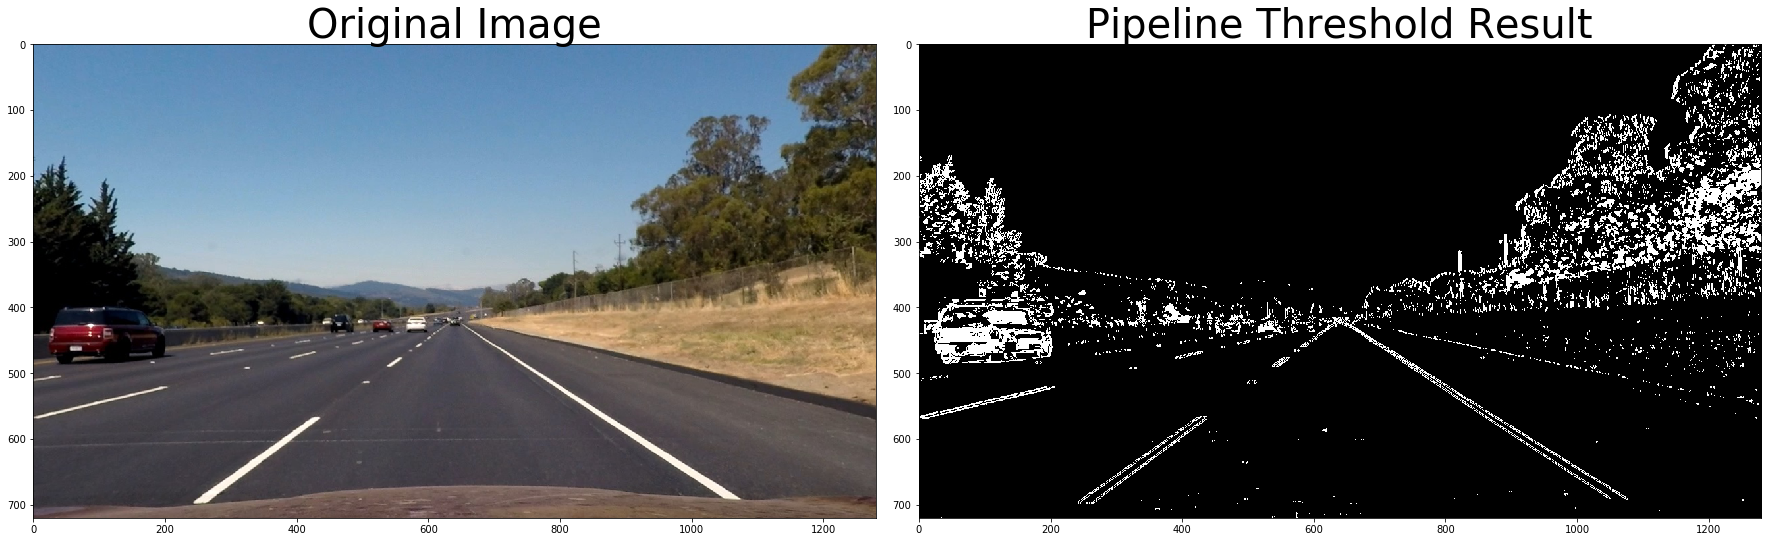

In [466]:
image = dst
undst = dst
result = pipeline_threshold(image)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap = 'gray')
ax2.set_title('Pipeline Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [467]:
#I already have mtx --> Calibration Matrix
# and dist --> Distortion Coeficients
#from the camera calibration of step 1... so I use them

def corners_unwarp(img, mtx, dist):

    # Undistort using mtx and dist   
    undst = cv2.undistort(img, mtx, dist, None, mtx)  
    img_size =(undst.shape[1], undst.shape[0])
    
    #top-right
    #bottom-right
    #bottom-left
    #top-left
    
    #source points (trapezoid)  
    src = np.float32(
    [[580, 460],
     [195, 720],
     [1127, 720],
     [705, 460]])
    
   
    #destination points (a rectangle)        
    dst = np.float32(
    [[320, 0],
     [320, 720],
     [960, 720], 
     [960, 0]])
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #calculate the inverse as well
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undst, M, img_size, flags=cv2.INTER_LINEAR)
 
    return warped, M, Minv, src, dst

Apply it the perspective transform

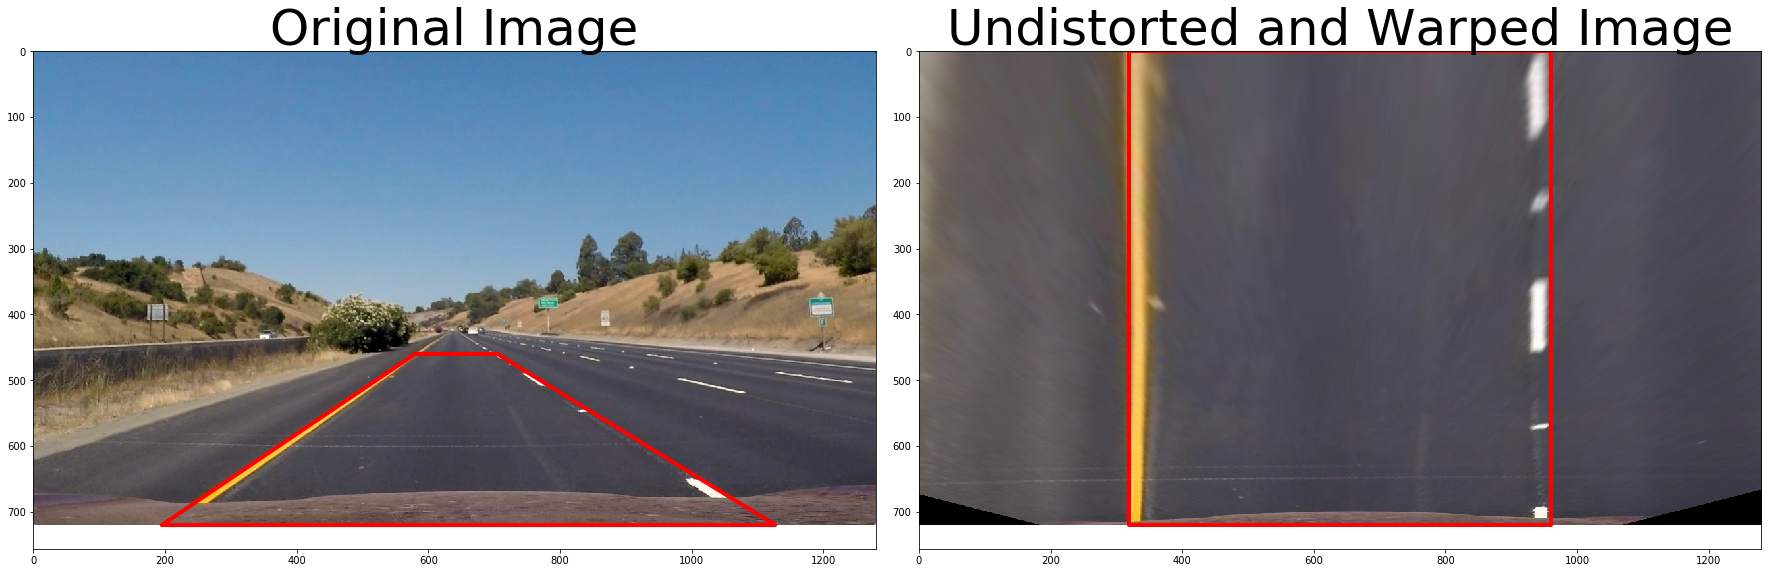

In [468]:
# Test on an image where lines are straight
img = cv2.imread('test_images/straight_lines1.jpg')

top_down, perspective_M, perspective_Minv, src, dst = corners_unwarp(img, mtx, dist)

x_src = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y_src = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]

x_dst = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y_dst = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.plot(x_src, y_src, 'r-', lw=4)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))
ax2.plot(x_dst, y_dst, 'r-', lw=4)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Now I apply perspective transform to rectify binary image

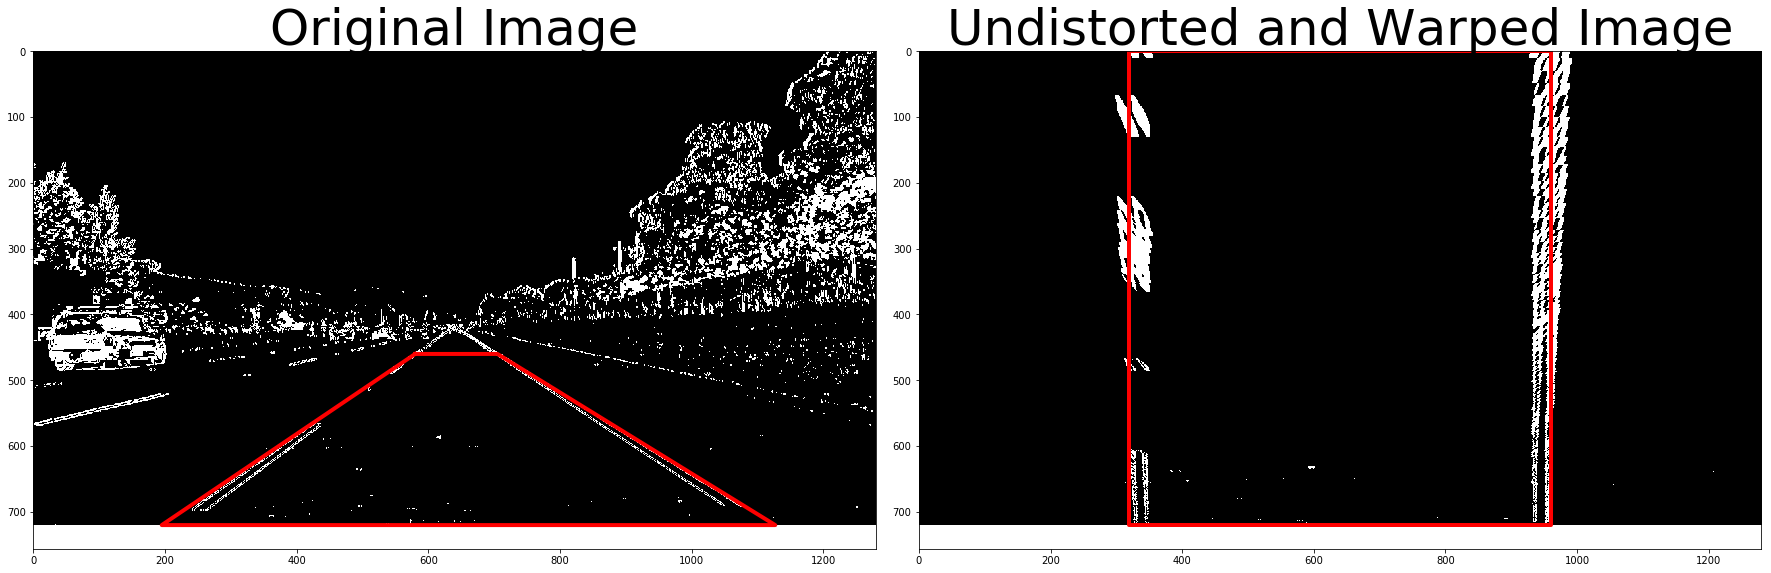

In [469]:
binary_warped, perspective_M, perspective_Minv, src, dst = corners_unwarp(result, mtx, dist)

x_src = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y_src = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]

x_dst = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y_dst = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result, cmap='gray')
ax1.plot(x_src, y_src, 'r-', lw=4)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(binary_warped, cmap='gray')
ax2.plot(x_dst, y_dst, 'r-', lw=4)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 5. Detect lane pixels and fit to find the lane boundary.

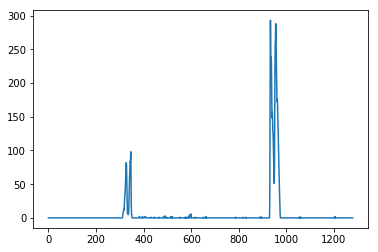

In [470]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [471]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

### Visualization


(720, 0)

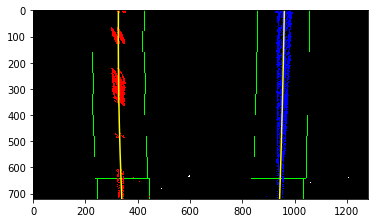

In [472]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0], binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 6. Determine the curvature of the lane and vehicle position with respect to center

First I do Radius in Pixels

In [473]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print('Left Radius: ', left_curverad)
print('Right Radius: ', right_curverad)

Left Radius:  14080.5333794
Right Radius:  43815.3561688


Now we have to convert this to the real world space. 
Assume (as indicated in the lesson) hat if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

In [474]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('Left curvature: ', left_curverad, 'm')
print('Right curvature: ', right_curverad, 'm')

Left curvature:  4611.69950251 m
Right curvature:  14367.733886 m


## 7. Warp the detected lane boundaries back onto the original image.

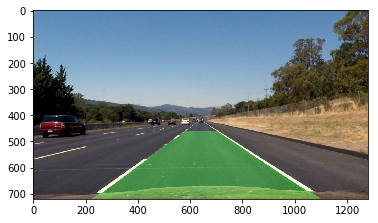

In [475]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
plt.imshow(result)